# 2.4

In [1]:
import pandas
from cardio_datasets import full_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Split data into test and validation sets

In [2]:
def create_X_y_from_data_frame(data_frame: pandas.DataFrame, target_column: str):
    """Returns a pandas.DataFrame's without target column and target column"""
    return data_frame.drop(columns=[target_column]), data_frame[target_column]

In [3]:
X, y = create_X_y_from_data_frame(full_dataset, 'cardio')
X_train_all, X_test_unseen, y_train_all, y_test_unseen = train_test_split(X,y,test_size=0.3,random_state=42)
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_train_all,y_train_all,test_size=0.3,random_state=42)

## Search and score parameters

In [4]:
def grid_search_hyper_parameters(X, y, unfitted_model, parameter_grid: dict, scoring_method: str):
    """Retruns a fitted model and a pandas.DataFrame of GridSearchCV.cv_results"""
    model = GridSearchCV(estimator=unfitted_model,param_grid=parameter_grid,return_train_score=False,scoring=scoring_method,cv=5)
    model.fit(X, y)
    return model, pandas.DataFrame(model.cv_results_)

In [5]:
def select_search_parameters_and_scores(results_data_frame:pandas.DataFrame, parameter_grid:dict):
    """Returns a selection of parameters and scores from a GridSearchCV.cv_results_ data frame using the keys from a parameter grid"""
    columns = ['param_' + key for key in list(parameter_grid.keys())] + ['mean_test_score', 'std_test_score']
    return results_data_frame[columns].sort_values('mean_test_score', ascending=False).reset_index(drop=True)

In [6]:
def search_hyper_parameters(X, y, unfitted_model, parameter_grid:dict, scoring_method:str):
    """Returns a fitted model, a selection of parameters and scores of GridSearchCV.cv_results_, raw GridSearchCV.cv_results_"""
    model, scores = grid_search_hyper_parameters(X, y, unfitted_model, parameter_grid, scoring_method)
    return model, select_search_parameters_and_scores(scores, parameter_grid), scores

In [7]:
pipeline_logistic_regression = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "LogisticRegression",
            LogisticRegression(
                solver="saga", multi_class="ovr", max_iter=10000, penalty="elasticnet"
            ),
        ),
    ]
)
pipeline_logistic_regression_parameter_grid = {"LogisticRegression__l1_ratio": [0, 1]}

(
    logistic_regression_model,
    logistic_regression_parameters_and_score,
    logistic_regression_score_raw,
) = search_hyper_parameters(
    X_train_eval,
    y_train_eval,
    pipeline_logistic_regression,
    pipeline_logistic_regression_parameter_grid,
    'recall'
)
logistic_regression_parameters_and_score

,param_LogisticRegression__l1_ratio,mean_test_score,std_test_score
0,0,0.665344,0.010179
1,1,0.665222,0.010338


TODO write about https://www.youtube.com/watch?v=HdlDYng8g9s

## Show classification score metrics

In [8]:
def show_classification_evaluation_metrics(model, X_test, y_test, display_labels=['True', 'False']):
    """Prints classification report and plots confusion matrix"""
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=display_labels).plot()

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      7177
           1       0.75      0.66      0.70      7061

    accuracy                           0.72     14238
   macro avg       0.73      0.72      0.72     14238
weighted avg       0.72      0.72      0.72     14238



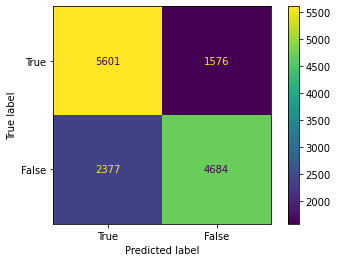

In [9]:
show_classification_evaluation_metrics(logistic_regression_model, X_test_eval, y_test_eval)

## Complete function

In [10]:
def search_score_and_evalute_parameters(X_train, X_test, y_train, y_test, model, model_parameter_grid:dict, scoring_method:str):
    """Searches, scores and prints evaluation of a model and it's parameters then returns the model, model_parameters_and_score, model_parameters_and_score_raw"""
    (
    fitted_model,
    model_parameters_and_score,
    model_parameters_and_score_raw
    ) = search_hyper_parameters(
        X_train,
        y_train,
        model,
        model_parameter_grid,
        scoring_method
    )
    show_classification_evaluation_metrics(fitted_model, X_test, y_test)
    return fitted_model, model_parameters_and_score, model_parameters_and_score_raw

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      7177
           1       0.75      0.66      0.70      7061

    accuracy                           0.72     14238
   macro avg       0.73      0.72      0.72     14238
weighted avg       0.72      0.72      0.72     14238



,param_LogisticRegression__l1_ratio,mean_test_score,std_test_score
0,0,0.665344,0.010179
1,1,0.665222,0.010338


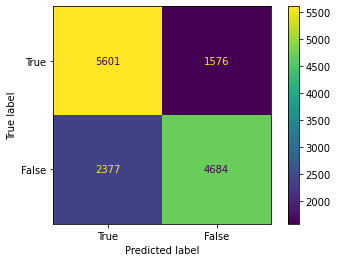

In [15]:
(logistic_regression_model, logistic_regression_model_scores, _) = search_score_and_evalute_parameters(
    X_train_eval,
    X_test_eval,
    y_train_eval,
    y_test_eval,
    pipeline_logistic_regression,
    pipeline_logistic_regression_parameter_grid,
    "recall",
)
logistic_regression_model_scores

## Test on unseen data

              precision    recall  f1-score   support

           0       0.71      0.79      0.74     10232
           1       0.76      0.67      0.71     10108

    accuracy                           0.73     20340
   macro avg       0.73      0.73      0.73     20340
weighted avg       0.73      0.73      0.73     20340



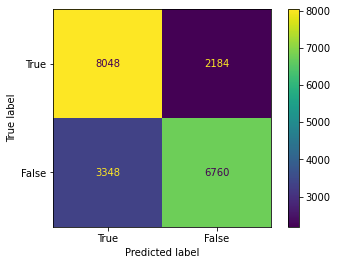

In [14]:
show_classification_evaluation_metrics(logistic_regression_model, X_test_unseen, y_test_unseen)

## Create dictionaries for each dataset
 - X, y, 
 - X_train_full, X_test_full, y_train_full, y_test_full
 - X_train_eval, X_test_eval, y_train_eval, y_test_eval 

In [ ]:
def create_train_test_eval_split(data_frame: pandas.DataFrame, target_column: str):
    "Returns dictionary with full_split and eval_split"
    X, y = create_X_y_from_data_frame(data_frame, target_column)
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
        X_train_full, y_train_full, test_size=0.3, random_state=42
    )
    return {
        "full_split": {
            "X_train": X_train_full,
            "X_test": X_test_full,
            "y_train": y_train_full,
            "y_test": y_test_full,
        },
        "eval_split": {
            "X_train": X_train_eval,
            "X_test": X_test_eval,
            "y_train": y_train_eval,
            "y_test": y_test_eval,
        },
    }

X_y_dictionary = create_train_test_eval_split(full_dataset, 'cardio')
X_y_dictionary.keys(), X_y_dictionary['full_split'].keys(), X_y_dictionary['eval_split'].keys()